# Date to ISO8601 Conversion


In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 1 - Translating human readable dates into machine readable dates

The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 



### 1.1 - Dataset

The model is trained on a dataset of 100000 human readable dates and their equivalent, standardized, machine readable dates.

In [2]:
m = 100000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 100000/100000 [00:07<00:00, 13361.73it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.09.70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('tuesday july 8 2008', '2008-07-08'),
 ('08 sep 1999', '1999-09-08'),
 ('1 jan 1981', '1981-01-01'),
 ('monday may 22 1995', '1995-05-22')]

## 2 - Neural machine translation with attention



### 2.1 - Attention mechanism

Here is a figure to remind you how the model works. The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>



Here are some properties of the model: 

- There are two separate LSTMs in this model (see diagram on the left). Because the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism, we will call it *pre-attention* Bi-LSTM. The LSTM at the top of the diagram comes *after* the attention mechanism, so we will call it the *post-attention* LSTM. The pre-attention Bi-LSTM goes through $T_x$ time steps; the post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes $s^{\langle t \rangle}, c^{\langle t \rangle}$ from one time step to the next. In the lecture videos, we were using only a basic RNN for the post-activation sequence model, so the state captured by the RNN output activations $s^{\langle t\rangle}$. But since we are using an LSTM here, the LSTM has both the output activation $s^{\langle t\rangle}$ and the hidden cell state $c^{\langle t\rangle}$. However, unlike previous text generation examples (such as Dinosaurus in week 1), in this model the post-activation LSTM at time $t$ does will not take the specific generated $y^{\langle t-1 \rangle}$ as input; it only takes $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ as input. We have designed the model this way, because (unlike language generation where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date. 

- We use $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-LSTM. 

- The diagram on the right uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times, and then `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ to compute $e^{\langle t, t'}$, which is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$. We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 



In [5]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

X.shape: (100000, 30)
Y.shape: (100000, 10)
Xoh.shape: (100000, 30, 37)
Yoh.shape: (100000, 10, 11)
Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Target after preprocessing (one-hot): [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [6]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [9]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas,a])
       
    return context

In [10]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0

    outputs = []
    
    # Step 1: Define your pre-attention Bi-LSTM. 
    a = Bidirectional(LSTM(n_a,return_sequences=True), merge_mode='concat',input_shape=(m, Tx, n_a*2))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t 
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        s, _, c = post_activation_LSTM_cell(context,initial_state = [s, c])
      
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM 
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list 
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. 
    model =  Model(inputs=[X,s0,c0],outputs=outputs)
    
    
    return model

In [11]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 30, 64)        17920       input_1[0][0]                    
____________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_1[0][0]            

In [12]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999,decay=0.01) 
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [13]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [16]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1
100000/100000 [==============================] - 348s - loss: 0.0199 - dense_3_loss_1: 2.6446e-04 - dense_3_loss_2: 1.5047e-04 - dense_3_loss_3: 3.3903e-04 - dense_3_loss_4: 7.4997e-04 - dense_3_loss_5: 6.2717e-06 - dense_3_loss_6: 0.0018 - dense_3_loss_7: 0.0020 - dense_3_loss_8: 7.3769e-06 - dense_3_loss_9: 0.0103 - dense_3_loss_10: 0.0043 - dense_3_acc_1: 1.0000 - dense_3_acc_2: 1.0000 - dense_3_acc_3: 1.0000 - dense_3_acc_4: 1.0000 - dense_3_acc_5: 1.0000 - dense_3_acc_6: 0.9995 - dense_3_acc_7: 0.9999 - dense_3_acc_8: 1.0000 - dense_3_acc_9: 0.9974 - dense_3_acc_10: 0.9991   


You can now see the results on new examples.

In [17]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-05-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


## 3 - Visualizing Attention 


Example of someone's birthday "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>





### 3.1 - Getting the activations from the network



In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 30, 64)        17920       input_1[0][0]                    
____________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_1[0][0]            

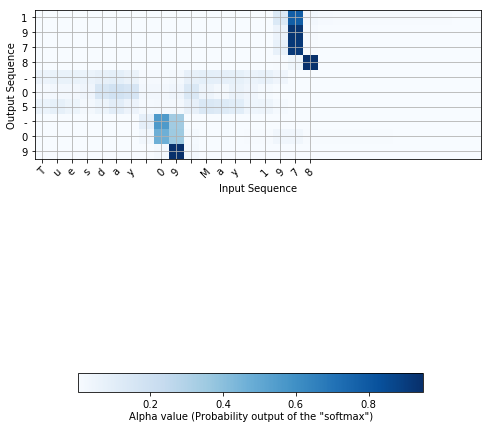

In [19]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 May 1978", num = 7, n_s = 64)